# Importing Required Libraries

In [1]:
import pandas as pd, warnings, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

# Disable all warning messages

In [2]:
warnings.filterwarnings("ignore")

# Defining Necessary Constants

In [3]:
SEED = 8576

# Loading processed data
TRAIN_DATA = pd.read_csv("train.csv")
VALIDATION_DATA = pd.read_csv("validation.csv")
TEST_DATA = pd.read_csv("test.csv")
N_JOBS = 1
SKIP_FINE_TUNING = False

# Benchmarking multiple models
MODELS = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state = SEED),
    "Support Vector Machine": SVC(random_state = SEED),
}

# Defining Necessary Functions

In [4]:
MODEL = [MultinomialNB | RandomForestClassifier | SVC]

# Function to fit a model on train data
def fit_model(
    train_data: pd.DataFrame,
    vectorizer: TfidfVectorizer,
    model: MODEL,
) -> (MODEL, TfidfVectorizer):
    X_train = vectorizer.fit_transform(train_data["text"])
    y_train = train_data["spam"]

    model.fit(X_train, y_train)

    return model, vectorizer

# Function to score a model on given data
def score_model(
    model: MODEL,
    vectorizer: TfidfVectorizer,
    data: pd.DataFrame,
) -> (float, str | dict, np.ndarray):
    X = vectorizer.transform(data["text"])
    y_true = data["spam"]

    y_pred = model.predict(X)

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names = ["Ham", "Spam"])
    confusion_mat = confusion_matrix(y_true, y_pred)

    return accuracy, report, confusion_mat

# Function to validate the model using cross-validation
def cross_validate_model(
    model: MODEL,
    vectorizer: TfidfVectorizer,
    data: pd.DataFrame,
) -> float:
    X = vectorizer.transform(data["text"])
    y = data["spam"]

    scores = cross_val_score(model, X, y, cv = 5, scoring = "accuracy")

    return scores.mean()

# Function to score and evaluate model
def score_and_evaluate_model_and_get_accuracy(
    model: MODEL,
    vectorizer: TfidfVectorizer,
    check_data: pd.DataFrame,
    check_data_type: str,
) -> float:
    check_accuracy, check_classification_report, check_confusion_mat = score_model(model, vectorizer, check_data)
    print(f"{check_data_type} Accuracy: {round(100 * check_accuracy, 2)} %")
    print(f"{check_data_type} Classification Report:\n{check_classification_report}")
    print(f"{check_data_type} Confusion Matrix:")
    display = ConfusionMatrixDisplay(confusion_matrix = check_confusion_mat, display_labels=['HAM', 'SPAM'])
    display.plot()
    plt.show()
    return check_accuracy

# Function to fine-tune the model based on train and validation
def fine_tune_model(
    model: MODEL,
    vectorizer: TfidfVectorizer,
    train_data: pd.DataFrame,
    validation_data: pd.DataFrame,
) -> MODEL:
    # Checking if Fine Tuning is needed
    if SKIP_FINE_TUNING:
        fine_tuning_needed = False
    else:
        # Always do fine tuning (No harm doing that, so why not?)
        fine_tuning_needed = True

    # if Fine Tuning is not needed, do nothing
    if not fine_tuning_needed:
        return model
    
    # Concatenating training and validation data for cross-validation
    combined_data = pd.concat([train_data, validation_data], axis = 0)

    # Defining param_grid
    if isinstance(model, MultinomialNB):
        param_grid = {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False],
        }
        model_name = "Multinomial Naive Bayes"
    if isinstance(model, RandomForestClassifier):
        param_grid = {
            "n_estimators": [100, 200],
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["auto", "sqrt"],
            "bootstrap": [True, False],
        }
        model_name = "Random Forest"
    if isinstance(model, SVC):
        param_grid = {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [2, 3, 4],
            "gamma": ["scale", "auto"],
            "shrinking": [True, False],
        }
        model_name = "Support Vector Machine"

    grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = "accuracy", n_jobs = N_JOBS)
    X_combined = vectorizer.transform(combined_data["text"])
    y_combined = combined_data["spam"]
    grid_search.fit(X_combined, y_combined)

    # Updating the model with the best hyperparameters
    model = grid_search.best_estimator_

    print(f"Best Hyper Parameter for {model_name}: {grid_search.best_params_}")
    print(f"Best Score for {model_name}: {grid_search.best_score_}")

    return model

# Selecting Best Model through Accuracy 

In [5]:
best_model = None
best_accuracy = 0

# Fitting Model for Multinomial Naive Bayes

In [6]:
model, vectorizer = fit_model(TRAIN_DATA, TfidfVectorizer(), MODELS["Multinomial Naive Bayes"])

# Scoring and Evaluating on Train Data for Multinomial Naive Bayes

Train Data Accuracy: 93.98 %
Train Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.93      1.00      0.96      3328
        Spam       1.00      0.75      0.86      1075

    accuracy                           0.94      4403
   macro avg       0.96      0.88      0.91      4403
weighted avg       0.94      0.94      0.94      4403

Train Data Confusion Matrix:


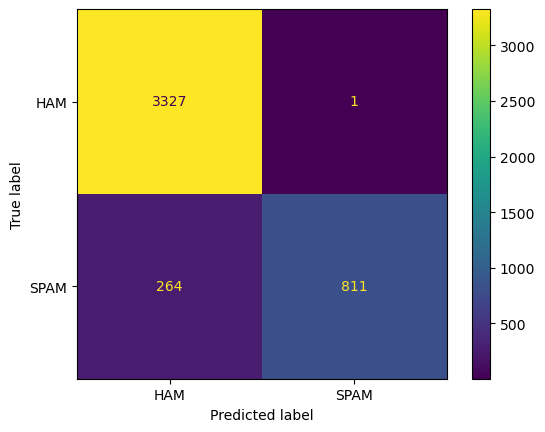

In [7]:
_ = score_and_evaluate_model_and_get_accuracy(model, vectorizer, TRAIN_DATA, "Train Data")

# Scoring and Evaluating on Validation Data for Multinomial Naive Bayes

Validation Data Accuracy: 90.55 %
Validation Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.89      1.00      0.94       412
        Spam       1.00      0.62      0.77       138

    accuracy                           0.91       550
   macro avg       0.94      0.81      0.85       550
weighted avg       0.92      0.91      0.90       550

Validation Data Confusion Matrix:


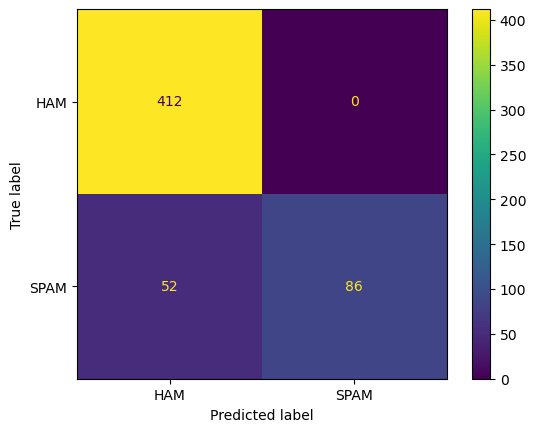

In [8]:
_ = score_and_evaluate_model_and_get_accuracy(model, vectorizer, VALIDATION_DATA, "Validation Data")

# Fine Tune the Multinomial Naive Bayes Model

In [9]:
model = fine_tune_model(model, vectorizer, TRAIN_DATA, VALIDATION_DATA)

Best Hyper Parameter for Multinomial Naive Bayes: {'alpha': 0.1, 'fit_prior': False}
Best Score for Multinomial Naive Bayes: 0.9905089237480761


# Scoring and Evaluating on Test Data for Multinomial Naive Bayes

Test Data Accuracy: 99.27 %
Test Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       397
        Spam       1.00      0.97      0.99       154

    accuracy                           0.99       551
   macro avg       1.00      0.99      0.99       551
weighted avg       0.99      0.99      0.99       551

Test Data Confusion Matrix:


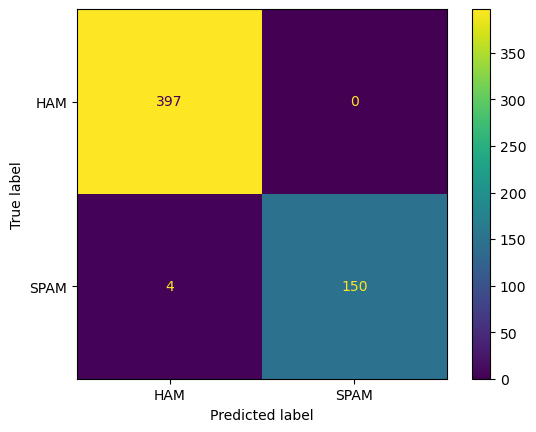

In [10]:
# Score on test
test_accuracy = score_and_evaluate_model_and_get_accuracy(model, vectorizer, TEST_DATA, "Test Data")

# Select the best model based on accuracy
if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_model = "Multinomial Naive Bayes"

# Fitting Model for Random Forest (If Necessary)

In [11]:
model, vectorizer = fit_model(TRAIN_DATA, TfidfVectorizer(), MODELS["Random Forest"])

# Scoring and Evaluating on Train Data for Random Forest

Train Data Accuracy: 100.0 %
Train Data Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00      3328
        Spam       1.00      1.00      1.00      1075

    accuracy                           1.00      4403
   macro avg       1.00      1.00      1.00      4403
weighted avg       1.00      1.00      1.00      4403

Train Data Confusion Matrix:


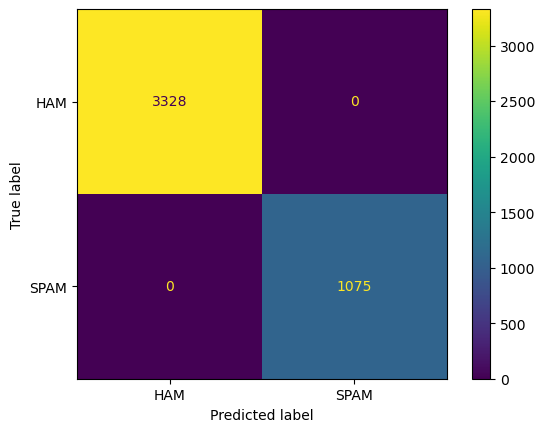

In [12]:
_ = score_and_evaluate_model_and_get_accuracy(model, vectorizer, TRAIN_DATA, "Train Data")

# Scoring and Evaluating on Validation Data for Random Forest

Validation Data Accuracy: 98.18 %
Validation Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       412
        Spam       1.00      0.93      0.96       138

    accuracy                           0.98       550
   macro avg       0.99      0.96      0.98       550
weighted avg       0.98      0.98      0.98       550

Validation Data Confusion Matrix:


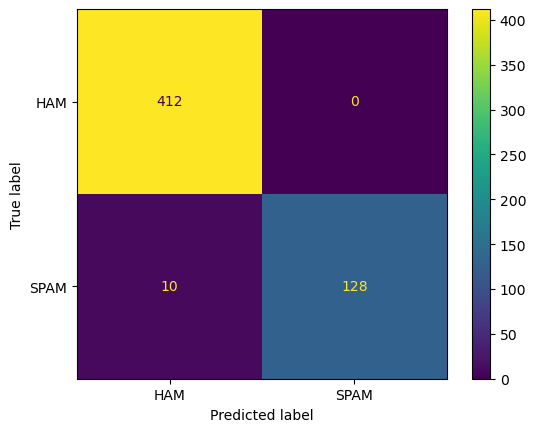

In [13]:
_ = score_and_evaluate_model_and_get_accuracy(model, vectorizer, VALIDATION_DATA, "Validation Data")

# Fine Tune the Random Forest Model (If Necessary)

In [14]:
model = fine_tune_model(model, vectorizer, TRAIN_DATA, VALIDATION_DATA)

Best Hyper Parameter for Random Forest: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score for Random Forest: 0.9852633295620178


# Scoring and Evaluating on Test Data for Random Forest

Test Data Accuracy: 98.37 %
Test Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       397
        Spam       0.99      0.95      0.97       154

    accuracy                           0.98       551
   macro avg       0.99      0.97      0.98       551
weighted avg       0.98      0.98      0.98       551

Test Data Confusion Matrix:


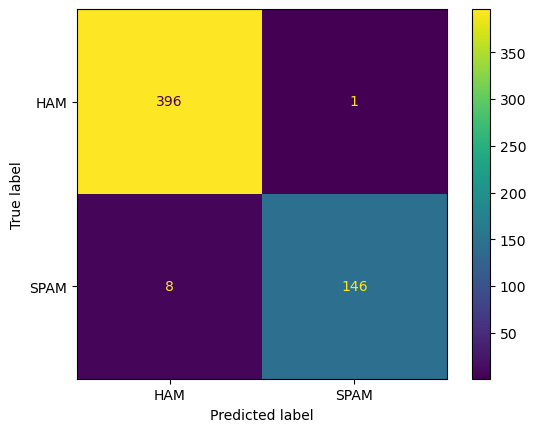

In [15]:
# Score on test
test_accuracy = score_and_evaluate_model_and_get_accuracy(model, vectorizer, TEST_DATA, "Test Data")

# Select the best model based on accuracy
if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_model = "Random Forest"

# Fitting Model for Support Vector Machine

In [16]:
model, vectorizer = fit_model(TRAIN_DATA, TfidfVectorizer(), MODELS["Random Forest"])

# Scoring and Evaluating on Train Data for Support Vector Machine

Train Data Accuracy: 100.0 %
Train Data Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00      3328
        Spam       1.00      1.00      1.00      1075

    accuracy                           1.00      4403
   macro avg       1.00      1.00      1.00      4403
weighted avg       1.00      1.00      1.00      4403

Train Data Confusion Matrix:


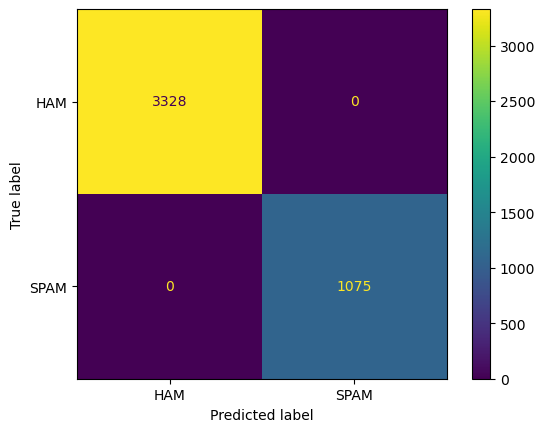

In [17]:
_ = score_and_evaluate_model_and_get_accuracy(model, vectorizer, TRAIN_DATA, "Train Data")

# Scoring and Evaluating on Validation Data for Support Vector Machine

Validation Data Accuracy: 98.18 %
Validation Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       412
        Spam       1.00      0.93      0.96       138

    accuracy                           0.98       550
   macro avg       0.99      0.96      0.98       550
weighted avg       0.98      0.98      0.98       550

Validation Data Confusion Matrix:


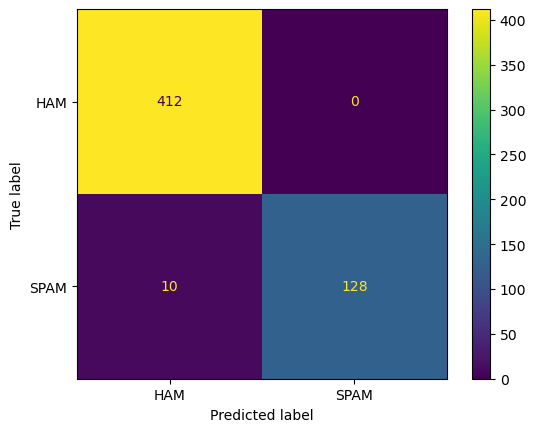

In [18]:
_ = score_and_evaluate_model_and_get_accuracy(model, vectorizer, VALIDATION_DATA, "Validation Data")

# Fine Tune the Support Vector Machine Model (If Necessary)

In [19]:
model = fine_tune_model(model, vectorizer, TRAIN_DATA, VALIDATION_DATA)

Best Hyper Parameter for Random Forest: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score for Random Forest: 0.9852633295620178


# Scoring and Evaluating on Test Data for Support Vector Machine

Test Data Accuracy: 98.37 %
Test Data Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       397
        Spam       0.99      0.95      0.97       154

    accuracy                           0.98       551
   macro avg       0.99      0.97      0.98       551
weighted avg       0.98      0.98      0.98       551

Test Data Confusion Matrix:


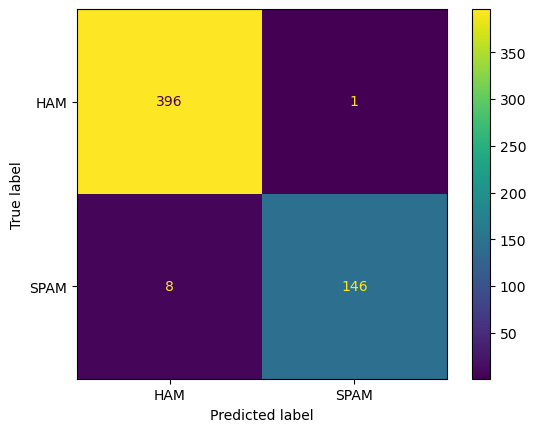

In [20]:
# Score on test
test_accuracy = score_and_evaluate_model_and_get_accuracy(model, vectorizer, TEST_DATA, "Test Data")

# Select the best model based on accuracy
if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_model = "Support Vector Machine"

In [21]:
print(f"\nBest Model: {best_model} with Test Accuracy: {round(100 * best_accuracy, 2)} %")


Best Model: Multinomial Naive Bayes with Test Accuracy: 99.27 %
